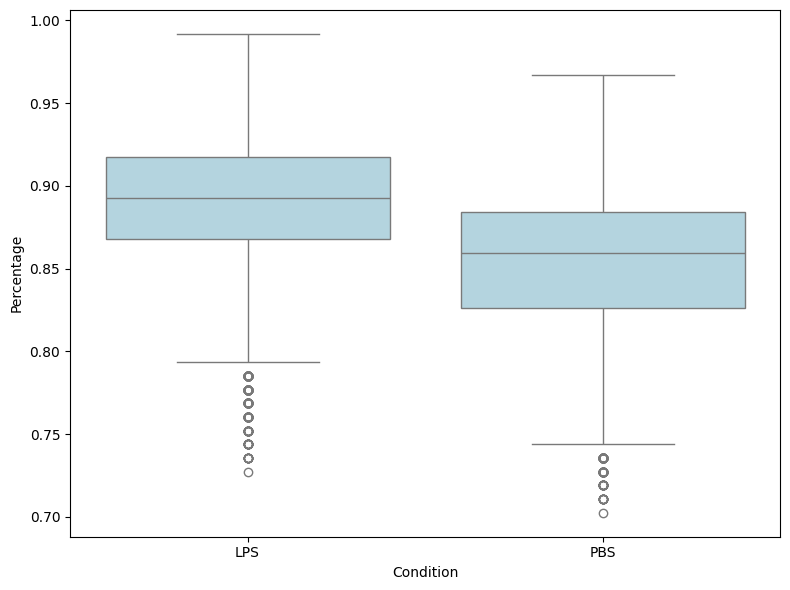

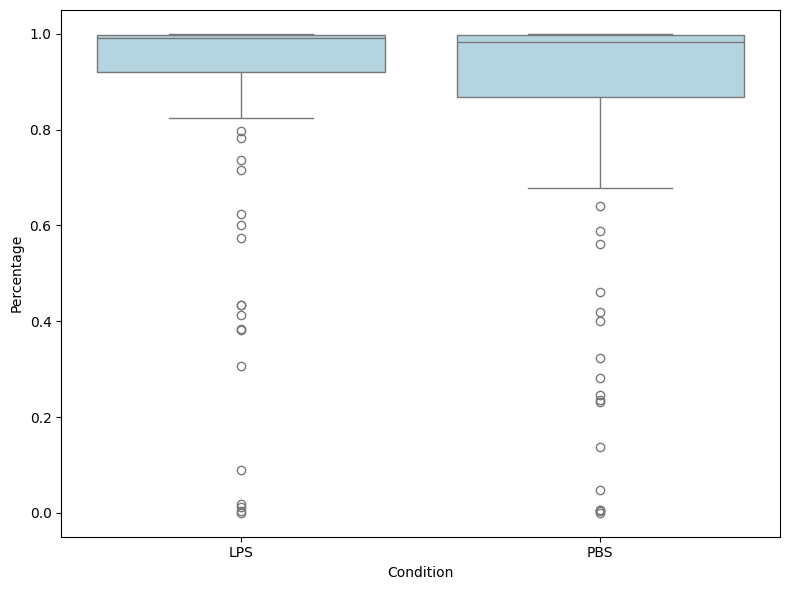

In [ ]:

import scanpy as sc
import numpy as np
import pandas as pd

import argparse
import seaborn as sns
import sys
import logging
import configparser
import anndata
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
import os
import argparse
import copy
import h5py



def read_dna_count_matrix(filename):
    with h5py.File(filename, "r") as file:
        amplicon_matrix = file['assays']['dna_read_counts']['layers']['read_counts'][:]
    return amplicon_matrix


def construct_amplicon_df(threshold=5):

    lps = read_dna_count_matrix("/mnt/data/project/stag_analysis/data/wholeTranscriptomics/WholeTranscriptomics_LPS.dna.h5")
    pbs = read_dna_count_matrix("/mnt/data/project/stag_analysis/data/wholeTranscriptomics/WholeTranscriptomics_PBS.dna.h5")

    lps_cell_level_qc = (lps > threshold).sum(axis=1)/lps.shape[1]
    lps_amplicon_level_qc = (lps > threshold).sum(axis=0)/lps.shape[0]

    pbs_cell_level_qc = (pbs > threshold).sum(axis=1)/pbs.shape[1]
    pbs_amplicon_level_qc = (pbs > threshold).sum(axis=0)/pbs.shape[0]

    df_cell = pd.DataFrame({
        "Percentage": np.concat([lps_cell_level_qc, pbs_cell_level_qc]),
        "Condition": ["LPS"]*len(lps_cell_level_qc) + ["PBS"]*len(pbs_cell_level_qc) 
    })

    df_amplicon = pd.DataFrame({
        "Percentage": np.concat([lps_amplicon_level_qc, pbs_amplicon_level_qc, ]),
        "Condition": ["LPS"]*len(lps_amplicon_level_qc) + ["PBS"]*len(pbs_amplicon_level_qc) })
    # import pdb; pdb.set_trace()
    return df_cell, df_amplicon
    

def boxplot_quality(df_cell, df_amplicon):
    color = "lightblue"
    # Create a boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="Condition", y="Percentage", data=df_cell, color=color)

    # Ensure the y-axis is set from 0 to 1
    #plt.ylim(0, 1)

    # Add labels and title
    plt.xlabel("Condition")
    plt.ylabel("Percentage")
    # plt.title("Boxplot for 121 complicon condition")
    plt.tight_layout()
    #plt.savefig("cell_level_quality_box.png", dpi=300)
    #plt.savefig("cell_level_quality_box.svg", dpi=300)


    # Create a boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="Condition", y="Percentage", data=df_amplicon, color=color)

    # Ensure the y-axis is set from 0 to 1
    #plt.ylim(0, 1)

    # Add labels and title
    plt.xlabel("Condition")
    plt.ylabel("Percentage")
    # plt.title("Boxplot for 121 complicon condition")
    plt.tight_layout()
    # plt.savefig("figures/amplicon_level_quality_box.png", dpi=300)
    # plt.savefig("figures/amplicon_level_quality_box.svg", dpi=300)
    plt.show()


def violinplot_quality(df_cell, df_amplicon):
    color = "lightblue"
    # Create a boxplot
    plt.figure(figsize=(8, 6))
    sns.violinplot(x="Condition", y="Percentage", data=df_cell, color=color)

    # Ensure the y-axis is set from 0 to 1
    #plt.ylim(0, 1)

    # Add labels and title
    plt.xlabel("Condition")
    plt.ylabel("Percentage")
    # plt.title("Boxplot for 121 complicon condition")
    plt.tight_layout()
    plt.savefig("cell_level_quality_violin.png", dpi=300)
    plt.savefig("cell_level_quality_violin.svg", dpi=300)


    # Create a boxplot
    plt.figure(figsize=(8, 6))
    sns.violinplot(x="Condition", y="Percentage", data=df_amplicon, color=color)

    # Ensure the y-axis is set from 0 to 1
    #plt.ylim(0, 1)

    # Add labels and title
    plt.xlabel("Condition")
    plt.ylabel("Percentage")
    # plt.title("Boxplot for 121 complicon condition")
    plt.tight_layout()
    plt.savefig("figures/amplicon_level_quality_violin.png", dpi=300)
    plt.savefig("figures/amplicon_level_quality_violin.svg", dpi=300)






if __name__ == "__main__":

    df_cell, df_amplicon = construct_amplicon_df(threshold=10)
    boxplot_quality(df_cell=df_cell, df_amplicon=df_amplicon)
    # violinplot_quality(df_cell=df_cell, df_amplicon=df_amplicon)
